# Programming Exercise 4 - Neural Networks Learning

1. [Neural Networks](#1-Neural-Networks)
    1. [Visualizing the data](#1.1-Visualizing-the-data)
    2. [Model representation](#1.2-Model-representation)
    3. [Feedforward and cost function](#1.3-Feedforward-and-cost-function)
    4. [Regularized cost function](#1.4-Regularized-cost-function)
2. [Backpropagation](#2-Backpropagation)
    1. [Sigmoid gradient](#2.1-Sigmoid-gradient)
    2. [Random initialization](#2.2-Random-initialization)
    3. [Backpropagation](#2.3-Backpropagation)
    4. [Gradient checking](#2.4-Gradient-checking)
    5. [Regularized Neural Networks](#2.5-Regularized-Neural-Networks)
    6. [Learning parameters](#2.6-Learning-parameters)
3. [Visualizing the hidden layer](#3-Visualizing-the-hidden-layer)
    1. [Optional overfitting](#3.1-Optional-overfitting)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid
from scipy.io import loadmat
from sklearn.preprocessing import label_binarize
from scipy.optimize import minimize
from IPython.display import display
% matplotlib inline


## 1 Neural Networks

In [2]:
data = loadmat("machine-learning-ex4/ex4/ex4data1.mat")
X, y = data["X"], data["y"]


### 1.1 Visualizing the data

In [3]:
def displayData(X):
    m, n = X.shape
    # Set example_width automatically if not passed in
    example_height = int(n ** (1 / 2))
    # convert to one line image containing all sample images
    img = np.vstack(np.hsplit(X.reshape(-1, example_height).T, int(m ** (1 / 2))))
    # Gray Image
    plt.axis('off')
    plt.imshow(img, cmap="gray")


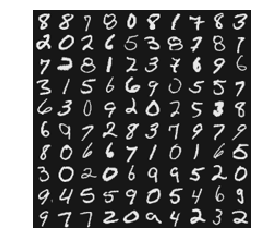

In [4]:
choices = np.random.choice(y.size, size=100)
displayData(X[choices])


### 1.2 Model representation

Our newral network has 3 layers - an input layer, a hidden layer and an output layer. Since the image are of size 20 x 20, this gives us 400 input layer units (not counting the extra bias unit which always outputs +1).

In [5]:
# Load saved matrices from file
data = loadmat("machine-learning-ex4/ex4/ex4weights.mat")
# The matrices Theta1 and Theta2 will now be in your workspace
# Theta1 has size 25 x 401
Theta1 = data["Theta1"]
# Theta2 has size 10 x 26
Theta2 = data["Theta2"]


![NeuralNetworkModel](NeuralNetworkModel.png)

### 1.3 Feedforward and cost function

In [6]:
def unroll_params(*params):
    return np.concatenate([p.ravel() for p in params])


In [7]:
def parse_params(nn_params, input_layer_size, hidden_layer_size, num_labels):
    Theta1 = nn_params[:hidden_layer_size * (input_layer_size + 1)].reshape((hidden_layer_size, input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape((num_labels, hidden_layer_size + 1))
    return Theta1, Theta2


$$
\begin{equation}
\begin{split}
l & = \text{layer $l$}\\
L & = \text{total number of layers in the network}\\
s_{(l)} & = \text{number of units (not counting bias unit) in $l^{th}$ layer}\\
K & = \text{number of output units/classes}\\
\sigma & = \text{activation function}\\
g & = \text{sigmoid function}\\
w^{(l)}_{jk} & = \text{the weights for the connection from the $k^{th}$ neuron in the $(l-1)^{th}$ layer to the $j^{th}$ neuron in the $l^{th}$ layer}\\
b^{(l)}_{j} & = \text{the bias of the $j^{th}$ neuron in the $l^{th}$ layer}\\
a^{(l)}_{j} & = \text{the activation of the $j^{th}$ neuron in the $l^{th}$ layer}\\
(a^{\prime})^{(l)} & = \text{ include a extra "bias" unit that always $a^{(l)}_{0} = 1$}\\
\Theta^{(l)} & = \text{matrix of weights controlling function mapping from layer $l$ to layer $l+1$, it will be of dimension $\big(s_{(l+1)}\,,\,s_{(l)} + 1\big)$}\\
\end{split}
\end{equation}
$$
![weight](./weight.png "weight")
![ActivationUnit](./ActivationUnit.png "ActivationUnit")

$$
\begin{equation}
\begin{split}
z^{(l)}_{j} & = \big(\sum^{s_{(l-1)}}_{k=1}w^{(l)}_{jk}a^{(l-1)}_{k}\big) + b^{(l)}_{j}\\
a^{(l)}_{j} & = \sigma(z^{(l)}_{j})\\
a^{(l)} & = \sigma(w^{(l)}a^{(l-1)} + b^{(l)})\\
\Theta^{(l)} & =
\begin{bmatrix}
    b^{(l+1)}_{1} & w^{(l+1)}_{11} & w^{(l+1)}_{12} & \dots & w^{(l+1)}_{1j}\\
    b^{(l+1)}_{2} & w^{(l+1)}_{21} & w^{(l+1)}_{22} & \dots & w^{(l+1)}_{2j}\\
    \dots         & \dots          & \dots          & \dots & \dots         \\
    b^{(l+1)}_{k} & w^{(l+1)}_{k1} & w^{(l+1)}_{k2} & \dots & w^{(l+1)}_{kj}\\
\end{bmatrix}\\
z^{(l+1)} & = \Theta^{(l)}(a^{\prime})^{(l)}\\
a^{(l+1)} & = g(z^{(l+1)}) \text{ if activation function is sigmoid}\\
h_{\Theta} & = a^{(L)} 
\end{split}
\end{equation}
$$

In [8]:
def feedforward(X, Theta1, Theta2):
    m, n = X.shape
    # Input Layer
    a1 = np.vstack((np.ones(m), X.T))  # 401x5000
    # Hidden Later
    z2 = Theta1.dot(a1)  # 25 x 5000
    a2 = np.vstack((np.ones(z2.shape[1]), sigmoid(z2)))  # 26 x 5000
    # Output Layer
    z3 = Theta2.dot(a2)  # 10 x 5000
    a3 = sigmoid(z3)
    return a1, a2, a3


### <center>cross-entropy cost function</center>
$$
J(\Theta) = -\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)+(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]
$$

The relative entropy or the Kullback-Leibler divergence $D_{KL}(p||q)$ is a measure of the difference between two probability distribution, and can be interpreted as the amount of information lost when Q is used to approxumate P. P typically represents the "true", empirical distribution from the data set, i.e. the distribution of true labels "$y$" given the inputs, while Q typically represents a theory model or approximation of P, i.e. the distribuition of $h(x)$ predicted by our classifier.

The cross entropy $H(p, q)$ and KL Divergence are related as:
$$H(p, q)=H(p) + D_{KL}(p||q)$$
The $p$ is fixed, H(p) is also fixed, doesn't change with the parameters of the model. So, it would be equivalent minimizing the cross-entropy as minimizing the KL divergence.

The cross entropy is proportional to the negative log likelihood, so minimizing it is equivalent maximizing the likelihood.
$$
\begin{equation}
\begin{split}
\mathcal{L}(\theta\mid y;x) & = p_{\theta}(y;x) = P_{\theta}(Y = y;x) = P(Y = y\mid x;\theta)\\
&= \prod^{k}_{label=1}\phi_{label}^{1\{y=label\}}\\
-log\,\mathcal{L} & = -\sum^{k}_{label=1}y_{label}log\,\hat{y}_{(label)} := H(y,\hat{y}) = H(p,q)\\
P(data\mid model) & = L(\theta;X,\vec{y}) = p(\vec{y}\mid X;\theta) = \prod^{m}_{i=1}\mathcal{L}(\theta\mid y^{(i)};x^{(i)})\\
l(\theta) & = log\,L(\theta)\\
-\frac{1}{m}l(\theta) & = \sum^{m}_{i=1}H(p_{i},q_{i}) := C_{x}\\
\arg\max_{\theta}l(\theta)&\text{ is same }\arg\min_{\theta}H(p,q)
\end{split}
\end{equation}
$$
$p$ is empirical probability distributions from a training set $y_{label} = p(y = label\mid x)$

$q$ is hypothetical probability distributions from our classifier $\phi_{label} = \hat{y}_{label} = p(y=label\mid x;\theta)$

We can also obtain cross-entropy Integrating this expression with respect to a:
$$
\begin{equation}
\begin{split}
\frac{\partial J}{\partial a} & = \frac{a-y}{a(1-a)}\\
\int\frac{a-y}{a(1-a)}\mathrm{d}a & = \int\big[\frac{1 - y}{1 - a} - \frac{y}{a}\big]\\
& = \int\frac{1 - y}{1 - a} - \int\frac{y}{a}\\
& = - (1 - y)(1 - a) - yln\,a\\
\text{cost from a sigle example} & = - \big[y\,ln\,a + (1 - y)\,ln\,(1 - a)\big] + constant\\
\end{split}
\end{equation}
$$

In [9]:
def _cost_without_divide(Theta1, Theta2, X, y, num_labels):
    y_matrix = label_binarize(y, classes=list(range(1, num_labels + 1)))
    a1, a2, a3 = feedforward(X, Theta1, Theta2)
    h = a3.T
    cost = -np.sum((np.log(h) * (y_matrix) + np.log(1 - h) * (1 - y_matrix)))
    return cost, a1, a2, a3, y_matrix


### 1.4 Regularized cost function

$$
J(\Theta)_{reg} = J(\Theta) + \frac{\lambda}{2m}\big[\sum_{l=1}^{L-1}\sum_{i=1}^{s_{l+1}}\sum_{j=1}^{s_{l}}(\Theta^{(l)}_{i,j})^{2}\big]
$$

In [10]:
def cost_reg(Theta1, Theta2, X, y, num_labels, lambda_):
    m, n = X.shape
    reg = lambda_ * (np.sum(np.square(Theta1[:, 1:])) + np.sum(np.square(Theta2[:, 1:]))) / 2
    cost, a1, a2, a3, y_matrix = _cost_without_divide(Theta1, Theta2, X, y, num_labels)
    return (cost + reg) / m, a1, a2, a3, y_matrix


In [11]:
# You should see that the cost is about 0.287629
np.testing.assert_approx_equal(cost_reg(Theta1, Theta2, X, y, 10, 0)[0], 0.287629, significant=6)
# You should see that the cost is about 0.383370
np.testing.assert_approx_equal(cost_reg(Theta1, Theta2, X, y, 10, 1)[0], 0.383770, significant=6)


## 2 Backpropagation

### 2.1 Sigmoid gradient

$$
\begin{equation}
\begin{split}
g'(z) & = g(z)(1 - g(z))\\
\text{where}\qquad g(z) & = \frac{1}{1+e^{-z}}
\end{split}
\end{equation}
$$

In [12]:
def sigmoidGradient(g_z, sigmoided = False):
    if not sigmoided:
        g_z = sigmoid(g_z)
    return g_z * (1 - g_z)


In [13]:
# try testing a few values by calling sigmoidGradient
# For large values (both positive and negative) of z, the gradient should be close to 0. When z = 0, the gradient should be exactly 0.25.
sigmoidGradient(np.array([-10, -1, -0.5, 0, 0.5, 1, 10]))


array([  4.53958077e-05,   1.96611933e-01,   2.35003712e-01,
         2.50000000e-01,   2.35003712e-01,   1.96611933e-01,
         4.53958077e-05])

### 2.2 Random initialization

In [14]:
# It is important to randomly initialize the parameters for symmetry breaking
# One effective strategy for random initialization is to 
# randomly select values for Theta uniformly in the range [-epsilon, +epsilon]
def randInitializeWeights(L_in, L_out):
    "Randomly initialize the weights to small values"
    # A good choice of epsilon is: sqrt(6) / sqrt(L_in + L_out)
    # where L_in = sl and L_out = sl+1
    epsion = 6 ** (1 / 2) / (L_in + L_out) ** (1 / 2)
    return np.random.uniform(-epsion, epsion, L_out * (L_in + 1)).reshape((L_out, L_in + 1))


### 2.3 Backpropagation

![NeuralNetworkModel](BackpropagationUpdates.png)

1. **Input a set of training examples**
2. **Per each training example** x:
    1. **Input** a training example x: Set the corresponding activation $a^{1}$ for the input layer
    2. **Feedforward**: For each $l=2,3,\dots,L$ compute $z^{(l)} = \Theta^{(l-1)}(a^{\prime})^{(l-1)}$ and $a^{(l)} = \sigma(z^{(l)})$
    3. **Output error** $\delta^{(L)}$: Compute the vector $\delta^{(L)} = \nabla_{a}J\odot\sigma^{\prime}(z^{(L)})$
    4. **Backpropagate the error**: For each $l=L-1, L-2, \dots, 2$ compute $\delta^{(l)} = (w^{(l+1)})^{T}\delta^{(l+1)}\odot\sigma^{\prime}(z^{(l)})$
    5. **Output**: The gradient of the cost function is given by $\frac{\partial J(\Theta)}{\partial b^{(l)}_{j}} = \delta^{(l)}_{j}$ and $
\frac{\partial J(\Theta)}{\partial w^{(l)}_{jk}} = a^{(l-1)}_{k}\delta^{(l)}_{j}$
3. **Accumulate** the gradient from simgle example
4. **Divide** the accumulated gradients by m
5. **Gradient descent**: For each $l$ update the weights and the biases

$$
\begin{equation}
\begin{split}
\delta^{(l)}_{j} & = \text{the "error term" of the $j^{th}$ neuron in the $l^{th}$ layer}\\
\delta^{(l)}_{j} & = \frac{\partial J(\Theta)}{\partial z^{(l)}_{j}}\\
\text{(if $l = L$) } \delta^{(L)}_{j} & = \frac{\partial J(\Theta)}{\partial a^{(l)}_{j}}\frac{\partial a^{(l)}_{j}}{\partial z^{(l)}_{j}} = \frac{\partial J(\Theta)}{\partial a^{(l)}_{j}}\sigma^{\prime}(z^{(l)}_{j})\\
\text{((if $l \neq L$) $\delta^{(l)}$ in terms of $\delta^{(l+1)}$) }\delta^{(l+1)}_{j} & = \sum^{s_{(l+1)}}_{k=1}\frac{\partial J(\Theta)}{\partial z^{(l+1)}_{k}}\frac{\partial z^{(l+1)}_{k}}{\partial z^{(l)}_{j}}\\
& = \sum^{s_{(l+1)}}_{k=1}\frac{\partial z^{(l+1)}_{k}}{\partial z^{(l)}_{j}}\delta^{(l+1)}_{k}\\
\frac{\partial z^{(l+1)}_{k}}{\partial z^{(l)}_{j}}\delta^{(l+1)}_{k} & = w^{(l+1)}_{kj}\sigma^{\prime}(z^{(l)}_{j})\\
\text{(substituting back into equation) }\delta^{(l+1)}_{j} & = w^{(l+1)}_{kj}\delta^{(l+1)}_{kj}\sigma^{\prime}(z^{(l)}_{j})\\
\frac{\partial J(\Theta)}{\partial b^{(l)}_{j}} & = \frac{\partial J(\Theta)}{\partial z^{(l)}_{j}}\frac{\partial z^{(l)}_{j}}{\partial b^{(l)}_{j}} = \delta^{(l)}_{j}\\
\frac{\partial J(\Theta)}{\partial w^{(l)}_{jk}} & = \frac{\partial J(\Theta)}{\partial z^{(l)}_{j}}\frac{\partial z^{(l)}_{j}}{\partial w^{(l)}_{jk}} = a^{(l-1)}_{k}\delta^{(l)}_{j}\\
\text{(vectorized form) }\delta^{(l)} & = \nabla_{z^{(l)}}J(\Theta)\\
\delta^{(L)} & = \nabla_{a^{(l)}}J(\Theta)\odot\sigma^{\prime}(z^{(l)})\\
\text{(if cost function is MSE) }\nabla_{a^{(L)}}J(\Theta) & = (a^{(L)} - \vec{y})\\
\text{(if cost function is cross-entropy) }\nabla_{a^{(L)}}J(\Theta) & = \frac{(a^{(L)} - \vec{y})}{\sigma(z)(1-\sigma(z))}\\
\text{if $\sigma$ is sigmoid function }\sigma^{\prime}(z^{(l)}) & = g^{\prime}(z^{(l)}) = a^{(l)}\odot(1-a^{(l)})\\
\text{so if activation function is sigmoid }&\text{and we use cross-entropy cost function then:}\\
\delta^{(L)} & = (a^{(L)} - \vec{y})\\
\delta^{(L-1)},\delta^{(L-2)},...,\delta^{(2)} \text{ using } \delta^{(l)} & = (w^{(l+1)})^{T}\delta^{(l+1)}\odot\sigma^{\prime}(z^{(l)})\\
\nabla_{b^{(l)}}J(\Theta) & = \delta^{(l)}\\
\nabla_{w^{(l)}}J(\Theta) & = \delta^{(l+1)}(a^{(l)})^{T}\\
\frac{\partial}{\partial\Theta_{ij}^{(l)}}J(\Theta) & = a_{j}^{(l)}\delta_{i}^{(l+1)}\qquad\text{(ignoring the regularization term)}\\
\end{split}
\end{equation}
$$

$$
\frac{\partial J(\Theta)}{\partial w^{(l)}_{jk}} = a^{(l-1)}_{k}\delta^{(l)}_{j} = a_{in}\delta_{out}
$$
![ConnectedNeuron](./ConnectedNeuron.png "ConnectedNeuron")
A consequence of this is that when the activation is small $a_{in}\approx 0$, the gradient term will also tend to be small. We'll say the weights output from low-activation neurons learns slowly. And also, the term $\sigma^{\prime}(z^{(l)}_{j})\approx 0$ if the neuron is either low activation ($\approx 0$) or high activation ($\approx 1$). In this case it's common to say the neuron has saturated. And $\delta^{(l)}_{j}$ is likely to get small if the neuron is near saturation. And this, in turn, means that any weights input to a saturated neuron will stop learning (or is learning slowly).
Summing up, we say a weight will learn slowly if either the input neuron is low-activation, or if the output neuron has saturated.

$$
\begin{equation}
\begin{split}
\Delta^{(l)} & = \Delta^{(l)} + \delta^{(l+1)}(a^{(l)})^{T}\\
\frac{\partial}{\partial{\Theta_{ij}^{(l)}}}J(\Theta) & = D_{ij}^{(l)}\\
D_{ij}^{(l)} & =
\begin{cases}
    \frac{1}{m}\Delta_{ij}^{(l)},& \text{if } j=0\\
    \frac{1}{m}(\Delta_{ij}^{(l)}+\lambda\Theta_{ij}^{(l)}),              & \text{if } j\neq0\\
\end{cases}
\end{split}
\end{equation}
$$

In [15]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, _lambda = 1):
    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1, Theta2 = parse_params(nn_params, input_layer_size, hidden_layer_size, num_labels)
    m, n = X.shape
    cost, a1, a2, a3, y_matrix = cost_reg(Theta1, Theta2, X, y, num_labels, _lambda)
    delta3 = a3 - y_matrix.T  # 10 x 5000
    delta2 = Theta2.T.dot(delta3) * sigmoidGradient(a2, sigmoided=True)  # 26 x 5000
    Delta2 = delta3.dot(a2.T)  # 10 x 26
    Delta1 = delta2[1:].dot(a1.T)  # 25 X 401
    if _lambda:
        Delta1[:, 1:] += _lambda * Theta1[:, 1:]
        Delta2[:, 1:] += _lambda * Theta2[:, 1:]
    return cost, unroll_params(Delta1, Delta2) / m


In [16]:
nn_params = unroll_params(Theta1, Theta2)
nnCostFunction(nn_params, X.shape[1], 25, 10, X, y, 0)


(0.28762916516131892,
 array([  6.18712766e-05,   0.00000000e+00,   0.00000000e+00, ...,
          9.66104721e-05,  -7.57736846e-04,   7.73329872e-04]))

### 2.4 Gradient checking

$$
\begin{equation}
\text{Let}\qquad
\theta^{i+} = \theta + 
\begin{bmatrix}
    0\\
    0\\
    ...\\
    \epsilon\\
    ...\\
    0\\
\end{bmatrix}
\qquad\text{and}\qquad
\theta^{i+} = \theta - 
\begin{bmatrix}
    0\\
    0\\
    ...\\
    \epsilon\\
    ...\\
    0\\
\end{bmatrix}\\
f_{i}(\theta) \approx \frac{J(\theta^{i+}-J(\theta^{i-})}{2\epsilon}\\
\end{equation}
$$

When performing gradient checking, it is much more efficient to use a small neural network with a relatively small number of input units and hidden unist, thus having a relatively small number of parameters.

In [17]:
def computeNumericalGradient(J, theta):
    # numerical estimate of the gradient
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 10 ** -4
    for p in range(theta.size):
        # Set perturbation vector
        perturb[p] = e
        loss1 = J(theta - perturb)[0]
        loss2 = J(theta + perturb)[0]
        # Compute Numerical Gradient
        numgrad[p] = (loss2 - loss1) / (2 * e)
        perturb[p] = 0
    return numgrad


In [18]:
# Initialize the weights of a layer with 
# fan_in incoming connections and fan_out outgoing connections
def debugInitializeWeights(fan_out, fan_in):
    size = fan_out * (1 + fan_in)
    W = np.arange(1, size + 1).reshape(fan_out, 1 + fan_in, order="F")
    return np.sin(W) / 10


In [19]:
# Creates a small neural network to check the backpropagation gradients
# It will output the analytical gradients produced by your backprop code 
# and the numerical gradients (computed using computeNumericalGradient)
# These two gradient computations should result in very similar values.
def checkNNGradients(_lambda = 0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)
    # Reusing debugInitializeWeights to generate X
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = 1 + np.arange(1, m + 1) % num_labels

    # Unroll parameters
    nn_params = unroll_params(Theta1, Theta2)

    # Short hand for cost function
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, _lambda)

    cost, grad = costFunc(nn_params)
    numgrad = computeNumericalGradient(costFunc, nn_params)

    # Visually examine the two gradient computations.
    # The two columns you get should be very similar.
    _grad = np.stack((numgrad, grad))
    print(_grad)
    print('The above two columns you get should be very similar.')
    print('first: Numerical Gradient, second: Analytical Gradient')
    # print(np.std(_grad, axis=0))

    # Evaluate the norm of the difference between two solutions.
    # If you have a correct implementation, 
    # and assuming you used EPSILON = 0.0001 in computeNumericalGradient.m
    # then diff below should be less than 1e-9
    diff = np.linalg.norm(numgrad - grad) / np.linalg.norm(numgrad + grad)
    print("""If your backpropagation implementation is correct, 
    then the relative difference will be small (less than 1e-9).
    Relative Difference: %e""" % diff);
    assert diff < 10 ** -9


In [20]:
checkNNGradients()


[[ -9.27825235e-03  -3.04978487e-06  -1.75060084e-04  -9.62660640e-05
    8.89911959e-03   1.42869427e-05   2.33146358e-04   1.17982666e-04
   -8.36010761e-03  -2.59383093e-05  -2.87468731e-04  -1.37149709e-04
    7.62813550e-03   3.69883235e-05   3.35320351e-04   1.53247082e-04
   -6.74798369e-03  -4.68759764e-05  -3.76215583e-04  -1.66560292e-04
    3.14544970e-01   1.64090819e-01   1.64567932e-01   1.58339334e-01
    1.51127527e-01   1.49568335e-01   1.11056588e-01   5.75736494e-02
    5.77867378e-02   5.59235296e-02   5.36967009e-02   5.31542052e-02
    9.74006970e-02   5.04575855e-02   5.07530173e-02   4.91620841e-02
    4.71456249e-02   4.65597186e-02]
 [ -9.27825236e-03  -3.04978914e-06  -1.75060082e-04  -9.62660620e-05
    8.89911960e-03   1.42869443e-05   2.33146357e-04   1.17982666e-04
   -8.36010762e-03  -2.59383100e-05  -2.87468729e-04  -1.37149706e-04
    7.62813551e-03   3.69883234e-05   3.35320347e-04   1.53247082e-04
   -6.74798370e-03  -4.68759769e-05  -3.76215587e-04 

### 2.5 Regularized Neural Networks

In [21]:
# Cost at lambda = 5): this value should be about 0.576051)
np.testing.assert_approx_equal(cost_reg(Theta1, Theta2, X, y, 10, 3)[0], 0.576051, significant=6)
# Checking Backpropagation and Regularization)
# Check gradients by running checkNNGradients
checkNNGradients(3)


[[ -9.27825235e-03  -1.67679797e-02  -6.01744725e-02  -1.73704651e-02
    8.89911959e-03   3.94334829e-02  -3.19612287e-02  -5.75658668e-02
   -8.36010761e-03   5.93355565e-02   2.49225535e-02  -4.51963845e-02
    7.62813550e-03   2.47640974e-02   5.97717617e-02   9.14587966e-03
   -6.74798369e-03  -3.26881426e-02   3.86410548e-02   5.46101547e-02
    3.14544970e-01   1.18682669e-01   2.03987128e-01   1.25698067e-01
    1.76337550e-01   1.32294136e-01   1.11056588e-01   3.81928711e-05
    1.17148233e-01  -4.07588279e-03   1.13133142e-01  -4.52964427e-03
    9.74006970e-02   3.36926556e-02   7.54801264e-02   1.69677090e-02
    8.61628953e-02   1.50048382e-03]
 [ -9.27825236e-03  -1.67679797e-02  -6.01744725e-02  -1.73704651e-02
    8.89911960e-03   3.94334829e-02  -3.19612287e-02  -5.75658668e-02
   -8.36010762e-03   5.93355565e-02   2.49225535e-02  -4.51963845e-02
    7.62813551e-03   2.47640974e-02   5.97717617e-02   9.14587966e-03
   -6.74798370e-03  -3.26881426e-02   3.86410548e-02 

### 2.6 Learning parameters

In [22]:
passs, input_layer_size = X.shape
hidden_layer_size, passs = Theta1.shape
num_labels, passs = Theta2.shape


In [23]:
# Training Neural Network
def nn_training(iter = 50, _lambda = 1):
    initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    initial_nn_params = unroll_params(initial_Theta1, initial_Theta2)

    # After you have completed the assignment, change the MaxIter to a larger
    # value to see how more training helps.
    options = {
        'maxiter': iter
    }

    # You should also try different values of lambda

    # Create "short hand" for the cost function to be minimized
    # Now, costFunction is a function that takes in only one argument
    # (the neural network parameters)
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, X, y, _lambda)

    result = minimize(costFunc, initial_nn_params, method="CG", jac=True, options=options)
    Theta1_result, Theta2_result = parse_params(result.x, input_layer_size, hidden_layer_size, num_labels)
    display(result)
    return Theta1_result, Theta2_result


In [24]:
def check_accuracy(Theta1, Theta2, X, y):
    # PREDICT Predict the label of an input given a trained neural network
    # Input Layer
    a1 = X
    # Hidden Layer
    m, n = a1.shape
    z2 = np.column_stack((np.ones((m, 1)), a1)).dot(Theta1.T)
    a2 = sigmoid(z2)
    # Output Layer
    m, n = a2.shape
    z3 = np.column_stack((np.ones((m, 1)), a2)).dot(Theta2.T)
    a3 = sigmoid(z3)

    p = (np.argmax(a3, axis=1) + 1)
    return np.mean(p == y.ravel()) * 100


In [25]:
# accuracy of theta solution from loaded file
check_accuracy(Theta1, Theta2, X, y)


97.519999999999996

In [26]:
# If your implementation is correct, you should see a reported training accuracy of about 95.3%
# This  may  vary  by  about  1%  due  to  the random  initialization
Theta1_result1, Theta2_result1 = nn_training()
print(check_accuracy(Theta1_result1, Theta2_result1, X, y))


     fun: 0.4366721468311907
     jac: array([ -2.54337848e-03,  -1.57975626e-05,   4.91608716e-07, ...,
         7.00689354e-05,   2.88449503e-04,   6.02632021e-04])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 122
     nit: 50
    njev: 122
  status: 1
 success: False
       x: array([-0.47179453, -0.07898781,  0.00245804, ..., -2.32906727,
       -2.03625783,  1.85251218])

96.84


In [27]:
# set MaxIter to 400) and also vary the regularization parameter λ

Theta1_result2, Theta2_result2 = nn_training(400, 3)
print(check_accuracy(Theta1_result2, Theta2_result2, X, y))


     fun: 0.5623635124345855
     jac: array([  1.72954361e-04,  -6.66454553e-13,   1.24338233e-11, ...,
         1.08436114e-05,  -9.71239590e-07,   5.24113796e-06])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 861
     nit: 400
    njev: 861
  status: 1
 success: False
       x: array([ -1.46803934e+00,  -1.11075759e-09,   2.07230389e-08, ...,
        -1.90378164e+00,  -8.91662049e-02,   1.67216347e+00])

97.5


## 3 Visualizing the hidden layer

One way to understand what your neural network is learning is to visualize what the representation captured by the hidden units, that is to find which inputs will cause it to activate (that is, to have an activation value close to 1). Thus, we can visualize the "representation" using the Theta which map from the input layer to the hidden layer.

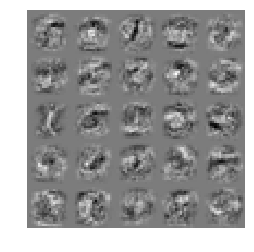

In [28]:
# You should find that the hidden units corresponds roughly 
# to detectors that look for strokes and other patterns in the input
displayData(Theta1_result2[:, 1:])


### 3.1 Optional overfitting

In [29]:
# Neural networks are very powerful models that can form highly complex decision boundaries.
# Without regularization, it is possible for a neural network to “overfit” a training set 
# so that it obtains close to 100% accuracy on the training set 
# but does not as well on new examples that it has not seen before
Theta1_result2, Theta2_result2 = nn_training(190, 0)
print(check_accuracy(Theta1_result2, Theta2_result2, X, y))


     fun: 0.005313723681862311
     jac: array([  6.37324027e-05,   0.00000000e+00,   0.00000000e+00, ...,
        -6.94341732e-06,   1.49136012e-06,   1.98206360e-05])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 591
     nit: 190
    njev: 591
  status: 1
 success: False
       x: array([ -1.47343783,  -0.01221523,   0.02407146, ...,  -7.2156074 ,
         2.23686014, -10.89279043])

100.0
